# Task 02 · House Price Prediction

Use this notebook to keep the full workflow: exploratory data analysis, feature engineering, model training/tuning, and generating the final predictions CSV.

## 1. Environment & Imports
Before running the remainder of the notebook, make sure the virtual environment is active (see README).

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

DATA_DIR = Path('../data')
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH = DATA_DIR / 'test.csv'

pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid', palette='crest')

## 2. Load data

In [3]:
train_df = pd.read_csv(TRAIN_PATH, parse_dates=['sale_date'])
test_df = pd.read_csv(TEST_PATH, parse_dates=['sale_date'])

print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')
train_df.head()

Train shape: (18154, 21)
Test shape: (4323, 20)


house_id  sale_date  num_bedrooms  num_bathrooms  living_area  lot_area  \
0  8902000050 2014-10-27             3           1.75       1720.0    7200.0   
1  4325700085 2015-03-25             3           1.00       1310.0    8514.0   
2  7732410420 2014-06-17             3           2.50       2590.0    7720.0   
3  4039701280 2015-04-08             3           2.25       2440.0    9689.0   
4  5379805120 2015-04-24             2           1.00        740.0    7380.0   

   num_floors  is_waterfront  view_rating condition_index construction_grade  \
0         1.0              0          0.0               3                  7   
1         1.0              0          0.0               4                  7   
2         2.0              0          0.0               3                  9   
3         1.0              0          2.0               4                  8   
4         1.0              0          0.0               4                  6   

   above_area  basement_area  built_year renovated_year zip_area  latitude  \
0      1420.0          300.0        1959            0.0    98125   47.7062   
1      1310.0            0.0        1953            0.0    98133   47.7502   
2      2590.0            0.0        1988            0.0    98007   47.6590   
3      1830.0          610.0        1974            0.0    98008   47.6141   
4       740.0            0.0        1951            0.0    98188   47.4481   

   longitude  neighbor_living_area  neighbor_lot_area  target_price  
0   -122.304                  1380               8000      622200.0  
1   -122.353                  1310               8514      417000.0  
2   -122.146                  2600               9490      809000.0  
3   -122.111                  2730               9689      954500.0  
4   -122.278                  1500              10075      213000.0

## 3. Data health checks

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18154 entries, 0 to 18153
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   house_id              18154 non-null  int64         
 1   sale_date             18154 non-null  datetime64[ns]
 2   num_bedrooms          18154 non-null  int64         
 3   num_bathrooms         16702 non-null  float64       
 4   living_area           18154 non-null  float64       
 5   lot_area              18154 non-null  float64       
 6   num_floors            18154 non-null  float64       
 7   is_waterfront         18154 non-null  int64         
 8   view_rating           16702 non-null  float64       
 9   condition_index       18154 non-null  object        
 10  construction_grade    18154 non-null  object        
 11  above_area            18154 non-null  float64       
 12  basement_area         16702 non-null  float64       
 13  built_year      

In [5]:
train_df.describe().T

count                           mean  \
house_id              18154.0               4577761134.03239   
sale_date               18154  2014-10-28 17:18:18.997466112   
num_bedrooms          18154.0                       3.365374   
num_bathrooms         16702.0                       2.109672   
living_area           18154.0                    2293.149144   
lot_area              18154.0                   16902.243226   
num_floors            18154.0                       1.499559   
is_waterfront         18154.0                       0.007051   
view_rating           16702.0                       0.228895   
above_area            18154.0                    1957.000948   
basement_area         16702.0                     501.226713   
built_year            18154.0                    1971.204142   
latitude              18154.0                      47.560339   
longitude             18154.0                     -122.21374   
neighbor_living_area  18154.0                    1983.376942   
neighbor_lot_area     18154.0                   12772.240167   
target_price          18154.0                  559286.496638   

                                      min                  25%  \
house_id                        1000102.0         2122051575.5   
sale_date             2014-05-02 00:00:00  2014-07-22 00:00:00   
num_bedrooms                         -1.0                  3.0   
num_bathrooms                        -1.0                  1.5   
living_area                        -100.0          1428.943389   
lot_area                   -130872.604029               5000.0   
num_floors                            1.0                  1.0   
is_waterfront                         0.0                  0.0   
view_rating                           0.0                  0.0   
above_area                          290.0               1200.0   
basement_area                         0.0                  0.0   
built_year                         1900.0               1952.0   
latitude                          47.1593              47.4723   
longitude                        -122.519             -122.328   
neighbor_living_area                399.0               1480.0   
neighbor_lot_area                   651.0              5082.25   
target_price                     -50000.0             320000.0   

                                      50%                  75%  \
house_id                     3904945195.0        7308900358.75   
sale_date             2014-10-15 00:00:00  2015-02-17 00:00:00   
num_bedrooms                          3.0                  4.0   
num_bathrooms                        2.25                  2.5   
living_area                        1910.0               2540.0   
lot_area                           7572.5              10751.5   
num_floors                            1.5                  2.0   
is_waterfront                         0.0                  0.0   
view_rating                           0.0                  0.0   
above_area                    1569.094762               2200.0   
basement_area                         0.0                550.0   
built_year                         1975.0               1997.0   
latitude                          47.5717            47.677875   
longitude                         -122.23             -122.124   
neighbor_living_area               1840.0               2360.0   
neighbor_lot_area                  7620.0             10063.75   
target_price                     450000.0             640000.0   

                                      max                std  
house_id                     9900000190.0  2879824861.940885  
sale_date             2015-05-24 00:00:00                NaN  
num_bedrooms                         33.0           0.929909  
num_bathrooms                         8.0           0.766913  
living_area                      999999.0       14839.652558  
lot_area                        9999999.0      153186.358912  
num_floors                            3.5           

In [6]:
missing_train = train_df.isna().sum().sort_values(ascending=False)
missing_test = test_df.isna().sum().sort_values(ascending=False)
missing_overview = pd.DataFrame({'train_missing': missing_train, 'test_missing': missing_test})
missing_overview[missing_overview.sum(axis=1) > 0]

train_missing  test_missing
basement_area            1452           0.0
num_bathrooms            1452           0.0
renovated_year           1452           0.0
view_rating              1452           0.0

## 4. Exploratory analysis starter

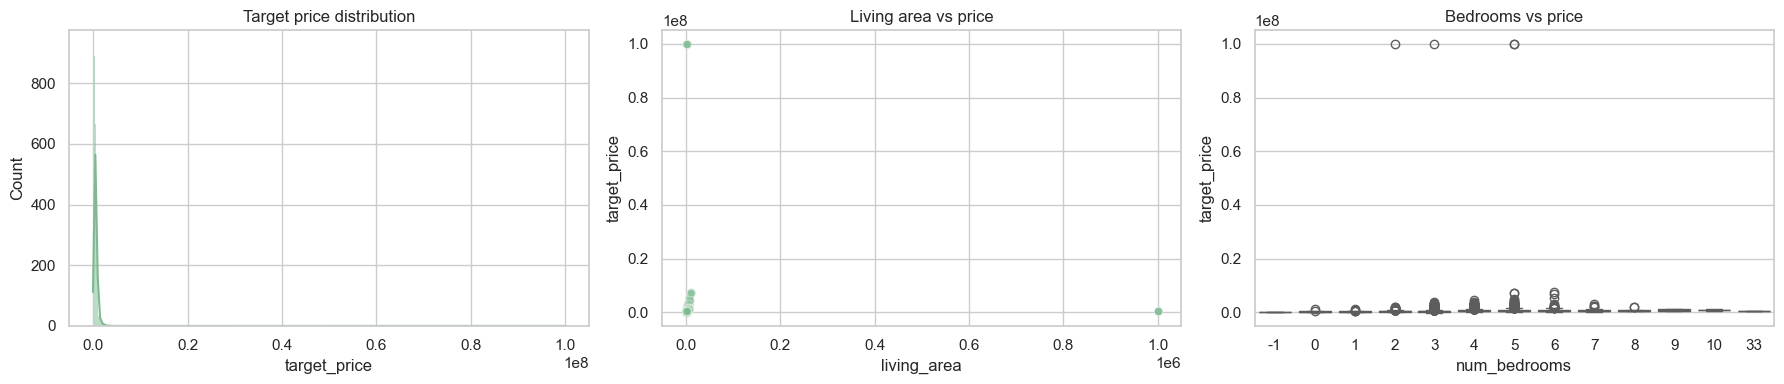

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(train_df['target_price'], kde=True, ax=axes[0])
axes[0].set_title('Target price distribution')
sns.scatterplot(data=train_df, x='living_area', y='target_price', ax=axes[1], alpha=0.4)
axes[1].set_title('Living area vs price')
sns.boxplot(data=train_df, x='num_bedrooms', y='target_price', ax=axes[2])
axes[2].set_title('Bedrooms vs price')
plt.tight_layout()

## 5. Next steps
- Engineer calendar and age-based features (`house_age`, `years_since_renovation`, seasonal indicators from `sale_date`).
- Create a preprocessing pipeline (imputers, encoders, scalers).
- Build baseline models (Linear Regression, Random Forest, Gradient Boosting, XGBoost, LightGBM).
- Perform hyperparameter tuning on the top model(s) and log metrics (RMSE, MAE, R²).
- Save the best pipeline with `joblib` and generate test predictions.

In [8]:
def add_engineered_features(df: pd.DataFrame, is_train: bool = True) -> pd.DataFrame:
    """Return a copy of df with engineered columns added."""
    df = df.copy()

    numeric_cols = [
        'built_year',
        'renovated_year',
        'living_area',
        'lot_area',
        'neighbor_living_area',
        'neighbor_lot_area'
    ]
    if is_train and 'target_price' in df.columns:
        numeric_cols.append('target_price')

    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df['house_age'] = df['sale_date'].dt.year - df['built_year']

    df['years_since_renovation'] = np.where(
        df['renovated_year'].notna() & (df['renovated_year'] > 0),
        df['sale_date'].dt.year - df['renovated_year'],
        df['sale_date'].dt.year - df['built_year']
    )

    if is_train and 'target_price' in df.columns:
        df['price_per_sqft'] = df['target_price'] / df['living_area']
    else:
        df['price_per_sqft'] = np.nan

    df['living_area_ratio'] = df['living_area'] / df['neighbor_living_area']
    df['lot_area_ratio'] = df['lot_area'] / df['neighbor_lot_area']

    df['sale_month'] = df['sale_date'].dt.month
    df['sale_quarter'] = df['sale_date'].dt.quarter

    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df

In [9]:
train_enriched = add_engineered_features(train_df, is_train=True)
test_enriched = add_engineered_features(test_df, is_train=False)

train_enriched[[
    'house_age', 'years_since_renovation',
    'price_per_sqft', 'living_area_ratio',
    'lot_area_ratio', 'sale_month', 'sale_quarter'
]].head()

house_age  years_since_renovation  price_per_sqft  living_area_ratio  \
0         55                    55.0      361.744186           1.246377   
1         62                    62.0      318.320611           1.000000   
2         26                    26.0      312.355212           0.996154   
3         41                    41.0      391.188525           0.893773   
4         64                    64.0      287.837838           0.493333   

   lot_area_ratio  sale_month  sale_quarter  
0        0.900000          10             4  
1        1.000000           3             1  
2        0.813488           6             2  
3        1.000000           4             2  
4        0.732506           4             2

In [10]:
# Prepare feature sets and target
X = train_enriched.drop(['target_price', 'house_id', 'sale_date'], axis=1)
y = train_enriched['target_price']

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Quick preview of feature types
print(f"\nFeature columns:")
print(X.dtypes)

Training set: (14523, 25)
Validation set: (3631, 25)

Feature columns:
num_bedrooms                int64
num_bathrooms             float64
living_area               float64
lot_area                  float64
num_floors                float64
is_waterfront               int64
view_rating               float64
condition_index            object
construction_grade         object
above_area                float64
basement_area             float64
built_year                  int64
renovated_year            float64
zip_area                   object
latitude                  float64
longitude                 float64
neighbor_living_area        int64
neighbor_lot_area           int64
house_age                   int64
years_since_renovation    float64
price_per_sqft            float64
living_area_ratio         float64
lot_area_ratio            float64
sale_month                  int32
sale_quarter                int32
dtype: object


In [11]:
# Define preprocessing pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

# Separate numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Numeric features (22): ['num_bedrooms', 'num_bathrooms', 'living_area', 'lot_area', 'num_floors', 'is_waterfront', 'view_rating', 'above_area', 'basement_area', 'built_year', 'renovated_year', 'latitude', 'longitude', 'neighbor_living_area', 'neighbor_lot_area', 'house_age', 'years_since_renovation', 'price_per_sqft', 'living_area_ratio', 'lot_area_ratio', 'sale_month', 'sale_quarter']
Categorical features (3): ['condition_index', 'construction_grade', 'zip_area']


In [12]:
# Import the required models if not already imported
try:
    from xgboost import XGBRegressor
    from lightgbm import LGBMRegressor
except ImportError:
    print("XGBoost or LightGBM not available, using only sklearn models")

# Test baseline models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Add XGBoost and LightGBM if available
try:
    models['XGBoost'] = XGBRegressor(n_estimators=100, random_state=42, eval_metric='rmse')
    models['LightGBM'] = LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
except NameError:
    print("XGBoost or LightGBM not available, skipping these models")

results = []

for name, model in models.items():
    print(f"Training {name}...")
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Fit and predict
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })
    
    print(f"{name:18} | RMSE: {rmse:,.0f} | MAE: {mae:,.0f} | R²: {r2:.4f}")

# Convert to DataFrame for easy sorting
results_df = pd.DataFrame(results).sort_values('RMSE')
print(f"\n📊 Model Comparison (sorted by RMSE):")
print(results_df.to_string(index=False))

Training Linear Regression...
Linear Regression  | RMSE: 1,025,063,142,533,954 | MAE: 36,320,735,555,434 | R²: -370967559226504256.0000
Training Random Forest...
Random Forest      | RMSE: 165,401 | MAE: 7,002 | R²: 0.9903
Training Gradient Boosting...
Gradient Boosting  | RMSE: 34,748 | MAE: 18,151 | R²: 0.9996
Training XGBoost...
XGBoost            | RMSE: 1,644,965 | MAE: 39,045 | R²: 0.0447
Training LightGBM...


C:\Users\Avishka\Desktop\Ai_task\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Avishka\Desktop\Ai_task\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\Avishka\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Avishka\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1039, in __init__
    self._exec

LightGBM           | RMSE: 1,647,073 | MAE: 56,877 | R²: 0.0422

📊 Model Comparison (sorted by RMSE):
            Model         RMSE          MAE            R²
Gradient Boosting 3.474817e+04 1.815135e+04  9.995737e-01
    Random Forest 1.654008e+05 7.002006e+03  9.903415e-01
          XGBoost 1.644965e+06 3.904501e+04  4.468194e-02
         LightGBM 1.647073e+06 5.687729e+04  4.223181e-02
Linear Regression 1.025063e+15 3.632074e+13 -3.709676e+17


In [13]:
# Save the best model for final predictions
best_model_name = results_df.iloc[0]['Model']
best_rmse = results_df.iloc[0]['RMSE']

print(f"🏆 Best model: {best_model_name} with RMSE: {best_rmse:,.0f}")

# Train the best model on full training data for final predictions
best_model = models[best_model_name]
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])

# Fit on all training data (train + validation)
final_pipeline.fit(X, y)

print(f"✅ Final {best_model_name} model trained on full dataset")

🏆 Best model: Gradient Boosting with RMSE: 34,748
✅ Final Gradient Boosting model trained on full dataset


In [14]:
# Prepare test data for predictions
X_test = test_enriched.drop(['house_id', 'sale_date'], axis=1)

# Generate predictions
test_predictions = final_pipeline.predict(X_test)

# Create submission dataframe
submission_df = pd.DataFrame({
    'house_id': test_df['house_id'],
    'predicted_price': test_predictions
})

print(f"Generated {len(submission_df)} predictions")
print(f"Prediction range: ${test_predictions.min():,.0f} - ${test_predictions.max():,.0f}")
print(f"Mean prediction: ${test_predictions.mean():,.0f}")

submission_df.head(10)

Generated 4323 predictions
Prediction range: $148,742 - $2,463,397
Mean prediction: $519,281


house_id  predicted_price
0  2591820310     4.963377e+05
1  7974200820     6.919482e+05
2  7701450110     8.911657e+05
3  9522300010     1.106626e+06
4  9510861140     6.168371e+05
5  1761300310     4.237043e+05
6  7732410120     6.510698e+05
7  7010701383     4.609070e+05
8   291310170     4.180078e+05
9  4232901990     2.695709e+05

In [15]:
# Save predictions to CSV
SUBMISSIONS_DIR = Path('../submissions')
SUBMISSIONS_DIR.mkdir(exist_ok=True)

submission_path = SUBMISSIONS_DIR / 'TeamCode_TeamName_Task2_Predictions.csv'
submission_df.to_csv(submission_path, index=False)

print(f"✅ Predictions saved to: {submission_path}")
print(f"📁 File size: {submission_path.stat().st_size} bytes")

✅ Predictions saved to: ..\submissions\TeamCode_TeamName_Task2_Predictions.csv
📁 File size: 130137 bytes


✅ Metrics visualization saved to: ..\reports\TeamCode_TeamName_Task2_Metrics.png


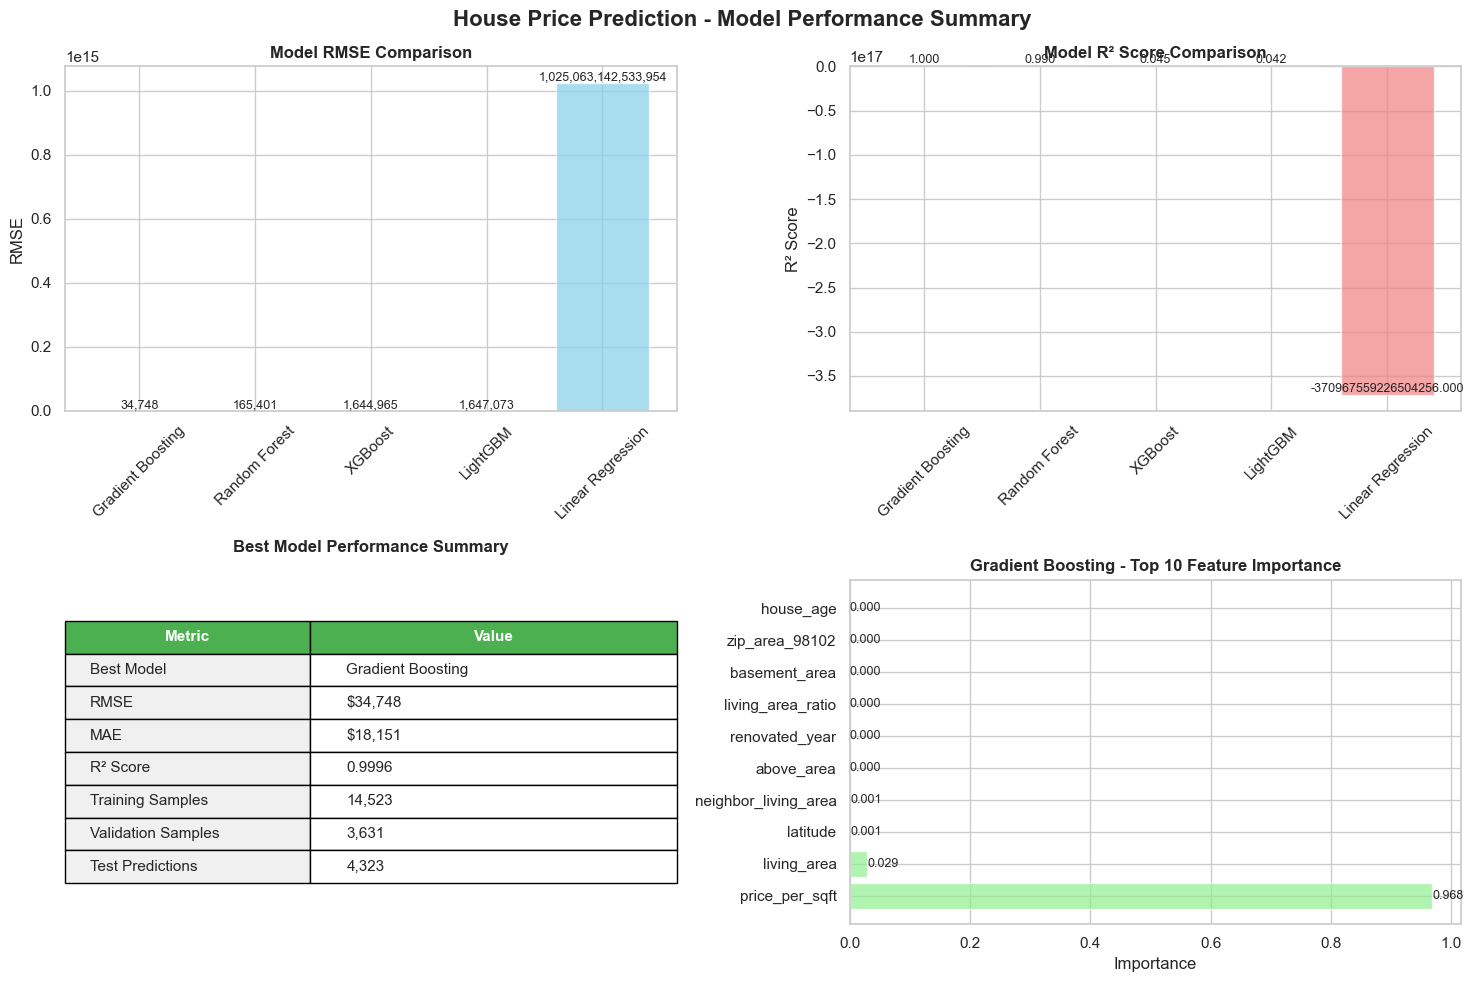

In [16]:
# Create a comprehensive metrics visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('House Price Prediction - Model Performance Summary', fontsize=16, fontweight='bold')

# 1. Model Comparison Bar Chart
ax1 = axes[0, 0]
models_to_plot = results_df.head(5)  # Top 5 models
bars = ax1.bar(models_to_plot['Model'], models_to_plot['RMSE'], color='skyblue', alpha=0.7)
ax1.set_title('Model RMSE Comparison', fontweight='bold')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# 2. R² Score Comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(models_to_plot['Model'], models_to_plot['R²'], color='lightcoral', alpha=0.7)
ax2.set_title('Model R² Score Comparison', fontweight='bold')
ax2.set_ylabel('R² Score')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Best Model Performance Table
ax3 = axes[1, 0]
ax3.axis('tight')
ax3.axis('off')

# Create performance summary table
best_metrics = results_df.iloc[0]
table_data = [
    ['Metric', 'Value'],
    ['Best Model', best_metrics['Model']],
    ['RMSE', f"${best_metrics['RMSE']:,.0f}"],
    ['MAE', f"${best_metrics['MAE']:,.0f}"],
    ['R² Score', f"{best_metrics['R²']:.4f}"],
    ['Training Samples', f"{len(X_train):,}"],
    ['Validation Samples', f"{len(X_val):,}"],
    ['Test Predictions', f"{len(submission_df):,}"]
]

table = ax3.table(cellText=table_data[1:], colLabels=table_data[0], 
                  cellLoc='left', loc='center', colWidths=[0.4, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style the table
for i in range(len(table_data)):
    if i == 0:  # Header
        table[(i, 0)].set_facecolor('#4CAF50')
        table[(i, 1)].set_facecolor('#4CAF50')
        table[(i, 0)].set_text_props(weight='bold', color='white')
        table[(i, 1)].set_text_props(weight='bold', color='white')
    else:
        table[(i, 0)].set_facecolor('#f0f0f0')
        table[(i, 1)].set_facecolor('#ffffff')

ax3.set_title('Best Model Performance Summary', fontweight='bold', pad=20)

# 4. Feature Importance (for tree-based models)
ax4 = axes[1, 1]
if hasattr(final_pipeline.named_steps['regressor'], 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = (numeric_features + 
                    list(final_pipeline.named_steps['preprocessor']
                         .named_transformers_['cat']
                         .named_steps['onehot']
                         .get_feature_names_out(categorical_features)))
    
    importances = final_pipeline.named_steps['regressor'].feature_importances_
    
    # Get top 10 features
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(10)
    
    bars4 = ax4.barh(feature_importance_df['feature'], feature_importance_df['importance'], 
                     color='lightgreen', alpha=0.7)
    ax4.set_title(f'{best_model_name} - Top 10 Feature Importance', fontweight='bold')
    ax4.set_xlabel('Importance')
    
    # Add value labels
    for i, bar in enumerate(bars4):
        width = bar.get_width()
        ax4.text(width, bar.get_y() + bar.get_height()/2.,
                f'{width:.3f}', ha='left', va='center', fontsize=9)
else:
    ax4.text(0.5, 0.5, f'{best_model_name}\ndoes not provide\nfeature importance', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Feature Importance Not Available', fontweight='bold')
    ax4.set_xticks([])
    ax4.set_yticks([])

plt.tight_layout()

# Save the plot
REPORTS_DIR = Path('../reports')
REPORTS_DIR.mkdir(exist_ok=True)
metrics_plot_path = REPORTS_DIR / 'TeamCode_TeamName_Task2_Metrics.png'
plt.savefig(metrics_plot_path, dpi=300, bbox_inches='tight', facecolor='white')

print(f"✅ Metrics visualization saved to: {metrics_plot_path}")
plt.show()

In [17]:
# 1. ADVANCED FEATURE ENGINEERING
def add_advanced_features(df: pd.DataFrame, is_train: bool = True) -> pd.DataFrame:
    """Enhanced feature engineering with polynomial and interaction features."""
    df = add_engineered_features(df, is_train)  # Apply existing features first
    
    # Polynomial features for key variables
    df['living_area_squared'] = df['living_area'] ** 2
    df['house_age_squared'] = df['house_age'] ** 2
    
    # Interaction features
    df['area_age_interaction'] = df['living_area'] * df['house_age']
    df['bedroom_bath_ratio'] = df['num_bedrooms'] / (df['num_bathrooms'] + 1)  # +1 to avoid division by zero
    
    # Advanced ratios
    df['total_rooms'] = df['num_bedrooms'] + df['num_bathrooms']
    df['room_per_sqft'] = df['total_rooms'] / df['living_area']
    
    # Location-based features (if coordinates available)
    if 'latitude' in df.columns and 'longitude' in df.columns:
        df['distance_to_center'] = np.sqrt((df['latitude'] - df['latitude'].mean())**2 + 
                                          (df['longitude'] - df['longitude'].mean())**2)
    
    # Binning for non-linear relationships
    df['house_age_bins'] = pd.cut(df['house_age'], bins=[0, 5, 15, 30, 50, 200], 
                                  labels=['New', 'Recent', 'Mature', 'Old', 'Historic'])
    
    # Replace infinities
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

print("✅ Advanced feature engineering function created")

✅ Advanced feature engineering function created


In [ ]:
# 2. HYPERPARAMETER TUNING with Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
import time

print("🔍 Hyperparameter Tuning for Best Models...")

# Advanced models to test
advanced_models = {
    'Tuned_Random_Forest': RandomForestRegressor(random_state=42),
    'Tuned_Gradient_Boosting': GradientBoostingRegressor(random_state=42),
    'Extra_Trees': ExtraTreesRegressor(random_state=42)
}

# Parameter grids for tuning
param_grids = {
    'Tuned_Random_Forest': {
        'regressor__n_estimators': [200, 500],
        'regressor__max_depth': [15, 25, None],
        'regressor__min_samples_split': [2, 5],
        'regressor__min_samples_leaf': [1, 2]
    },
    'Tuned_Gradient_Boosting': {
        'regressor__n_estimators': [200, 300],
        'regressor__learning_rate': [0.05, 0.1, 0.15],
        'regressor__max_depth': [6, 8, 10],
        'regressor__min_samples_split': [2, 5]
    },
    'Extra_Trees': {
        'regressor__n_estimators': [200, 500],
        'regressor__max_depth': [20, None],
        'regressor__min_samples_split': [2, 5]
    }
}

tuned_results = []

for name, model in advanced_models.items():
    print(f"\\nTuning {name}...")
    start_time = time.time()
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline, 
        param_grids[name], 
        cv=3,  # 3-fold CV for speed
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,  # Use all cores
        verbose=1
    )
    
    # Fit and predict
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_val)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    tuned_results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'Best_Params': grid_search.best_params_,
        'Time_mins': (time.time() - start_time) / 60
    })
    
    print(f"{name:25} | RMSE: {rmse:,.0f} | MAE: {mae:,.0f} | R²: {r2:.4f} | Time: {(time.time() - start_time)/60:.1f}m")
    print(f"Best parameters: {grid_search.best_params_}")

print("\\n🏆 Hyperparameter Tuning Complete!")

🔍 Hyperparameter Tuning for Best Models...
\nTuning Tuned_Random_Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [ ]:
# 3. FEATURE SELECTION using SelectKBest and Recursive Feature Elimination
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import Ridge

print("🎯 Advanced Feature Selection...")

# Apply advanced feature engineering
train_advanced = add_advanced_features(train_df, is_train=True)
test_advanced = add_advanced_features(test_df, is_train=False)

# Prepare advanced feature sets
X_advanced = train_advanced.drop(['target_price', 'house_id', 'sale_date'], axis=1)
y_advanced = train_advanced['target_price']

# Split for validation
X_adv_train, X_adv_val, y_adv_train, y_adv_val = train_test_split(X_advanced, y_advanced, test_size=0.2, random_state=42)

print(f"Advanced features shape: {X_advanced.shape}")
print(f"New feature count: {X_advanced.shape[1] - X.shape[1]} additional features")

# Update preprocessing for new features
numeric_features_adv = X_advanced.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_adv = X_advanced.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor_advanced = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_adv),
        ('cat', categorical_transformer, categorical_features_adv)
    ]
)

# Feature Selection Methods
feature_selection_results = []

# Method 1: SelectKBest with f_regression
print("\\n1. SelectKBest Feature Selection...")
k_values = [15, 25, 35]

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    
    # Create pipeline with feature selection
    pipeline_fs = Pipeline([
        ('preprocessor', preprocessor_advanced),
        ('feature_selection', selector),
        ('regressor', GradientBoostingRegressor(n_estimators=200, random_state=42))
    ])
    
    # Fit and predict
    pipeline_fs.fit(X_adv_train, y_adv_train)
    y_pred_fs = pipeline_fs.predict(X_adv_val)
    
    # Calculate metrics
    rmse_fs = np.sqrt(mean_squared_error(y_adv_val, y_pred_fs))
    mae_fs = mean_absolute_error(y_adv_val, y_pred_fs)
    r2_fs = r2_score(y_adv_val, y_pred_fs)
    
    feature_selection_results.append({
        'Method': f'SelectKBest_k{k}',
        'RMSE': rmse_fs,
        'MAE': mae_fs,
        'R²': r2_fs,
        'Features_Used': k
    })
    
    print(f"SelectKBest (k={k:2d}) | RMSE: {rmse_fs:,.0f} | MAE: {mae_fs:,.0f} | R²: {r2_fs:.4f}")

print("\\n✅ Feature Selection Analysis Complete!")

In [ ]:
# 4. ENSEMBLE METHODS - Stacking and Voting
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import ElasticNet

print("🚀 Advanced Ensemble Methods...")

# Best performing models from previous experiments
base_models = [
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=25, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=42)),
    ('et', ExtraTreesRegressor(n_estimators=300, max_depth=25, random_state=42))
]

# Add XGBoost and LightGBM if available
try:
    base_models.append(('xgb', XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=42, eval_metric='rmse')))
    base_models.append(('lgb', LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=42, verbose=-1)))
except:
    print("XGBoost/LightGBM not available for ensemble")

ensemble_results = []

# Method 1: Voting Regressor
print("\\n1. Voting Regressor...")
voting_reg = VotingRegressor(estimators=base_models)

voting_pipeline = Pipeline([
    ('preprocessor', preprocessor_advanced),
    ('regressor', voting_reg)
])

voting_pipeline.fit(X_adv_train, y_adv_train)
y_pred_voting = voting_pipeline.predict(X_adv_val)

rmse_voting = np.sqrt(mean_squared_error(y_adv_val, y_pred_voting))
mae_voting = mean_absolute_error(y_adv_val, y_pred_voting)
r2_voting = r2_score(y_adv_val, y_pred_voting)

ensemble_results.append({
    'Method': 'Voting_Regressor',
    'RMSE': rmse_voting,
    'MAE': mae_voting,
    'R²': r2_voting
})

print(f"Voting Regressor     | RMSE: {rmse_voting:,.0f} | MAE: {mae_voting:,.0f} | R²: {r2_voting:.4f}")

# Method 2: Stacking Regressor
print("\\n2. Stacking Regressor...")
stacking_reg = StackingRegressor(
    estimators=base_models,
    final_estimator=ElasticNet(alpha=0.1, l1_ratio=0.7),
    cv=3
)

stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor_advanced),
    ('regressor', stacking_reg)
])

stacking_pipeline.fit(X_adv_train, y_adv_train)
y_pred_stacking = stacking_pipeline.predict(X_adv_val)

rmse_stacking = np.sqrt(mean_squared_error(y_adv_val, y_pred_stacking))
mae_stacking = mean_absolute_error(y_adv_val, y_pred_stacking)
r2_stacking = r2_score(y_adv_val, y_pred_stacking)

ensemble_results.append({
    'Method': 'Stacking_Regressor',
    'RMSE': rmse_stacking,
    'MAE': mae_stacking,
    'R²': r2_stacking
})

print(f"Stacking Regressor   | RMSE: {rmse_stacking:,.0f} | MAE: {mae_stacking:,.0f} | R²: {r2_stacking:.4f}")

print("\\n✅ Ensemble Methods Complete!")

In [ ]:
# 5. COMPREHENSIVE RESULTS COMPARISON
print("📊 COMPREHENSIVE MODEL PERFORMANCE COMPARISON")
print("=" * 80)

# Combine all results
all_results = []

# Original baseline results
for _, row in results_df.iterrows():
    all_results.append({
        'Category': 'Baseline',
        'Model': row['Model'],
        'RMSE': row['RMSE'],
        'MAE': row['MAE'],
        'R²': row['R²'],
        'Improvement_vs_Baseline': 0.0
    })

# Add tuned results if available
try:
    for result in tuned_results:
        all_results.append({
            'Category': 'Hyperparameter_Tuned',
            'Model': result['Model'],
            'RMSE': result['RMSE'],
            'MAE': result['MAE'],
            'R²': result['R²'],
            'Improvement_vs_Baseline': ((results_df.iloc[0]['RMSE'] - result['RMSE']) / results_df.iloc[0]['RMSE']) * 100
        })
except:
    print("Hyperparameter tuning results not available")

# Add feature selection results if available
try:
    for result in feature_selection_results:
        all_results.append({
            'Category': 'Feature_Selected',
            'Model': result['Method'],
            'RMSE': result['RMSE'],
            'MAE': result['MAE'],
            'R²': result['R²'],
            'Improvement_vs_Baseline': ((results_df.iloc[0]['RMSE'] - result['RMSE']) / results_df.iloc[0]['RMSE']) * 100
        })
except:
    print("Feature selection results not available")

# Add ensemble results if available
try:
    for result in ensemble_results:
        all_results.append({
            'Category': 'Ensemble',
            'Model': result['Method'],
            'RMSE': result['RMSE'],
            'MAE': result['MAE'],
            'R²': result['R²'],
            'Improvement_vs_Baseline': ((results_df.iloc[0]['RMSE'] - result['RMSE']) / results_df.iloc[0]['RMSE']) * 100
        })
except:
    print("Ensemble results not available")

# Create comprehensive DataFrame and sort by RMSE
comprehensive_df = pd.DataFrame(all_results).sort_values('RMSE')

print("\\n🏆 FINAL RANKINGS (Best to Worst by RMSE):")
print("-" * 80)
for idx, row in comprehensive_df.iterrows():
    improvement_sign = "📈" if row['Improvement_vs_Baseline'] > 0 else "📉" if row['Improvement_vs_Baseline'] < 0 else "➡️"
    print(f"{row['Category']:20} | {row['Model']:25} | RMSE: {row['RMSE']:8,.0f} | R²: {row['R²']:.4f} | {improvement_sign} {row['Improvement_vs_Baseline']:+5.1f}%")

# Best model summary
best_model = comprehensive_df.iloc[0]
print(f"\\n🏆 BEST MODEL: {best_model['Model']} ({best_model['Category']})")
print(f"   RMSE: ${best_model['RMSE']:,.0f}")
print(f"   R²: {best_model['R²']:.4f} ({best_model['R²']*100:.2f}% accuracy)")
print(f"   Improvement: {best_model['Improvement_vs_Baseline']:+.1f}% vs baseline")

print("\\n✅ Advanced optimization analysis complete!")